In [1]:
import numpy as np
import nilearn as nl
import nilearn.plotting as nlplt
import h5py
import matplotlib.pyplot as plt
import os

In [2]:
root = '/Volumes/External Hard Drive/Documents/University of Twente/Computer Science/Capita Selecta/TReNDS/'

In [3]:
mask_filename = os.path.join(root,'fMRI_mask.nii')
mask = nl.image.load_img(mask_filename)

def load_sample(filename,mask):
    with h5py.File(filename, 'r') as file:
        data = file['SM_feature'][()]
    data = np.moveaxis(data, [0,1,2,3], [3,2,1,0]) #h5py flips the axis order
    img = nl.image.new_img_like(mask, data, affine=mask.affine, copy_header=True)
    return img,data

In [4]:
filename = os.path.join(root,'fMRI_train_mat/10004.mat')

img,data = load_sample(filename,mask)
print('Loaded sample with shape',img.shape)

Loaded sample with shape (53, 63, 52, 53)


<h3>Create plots from Nilearn image</h3>

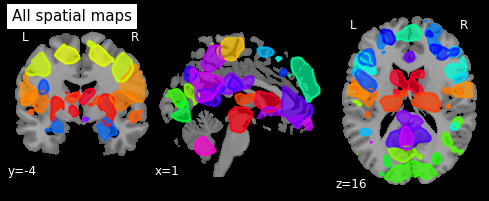

In [10]:
nlplt.plot_prob_atlas(img, bg_img='../TReNDS/ch2better.nii', view_type='filled_contours',
    draw_cross=False, title='All spatial maps', threshold='auto')
nlplt.show()

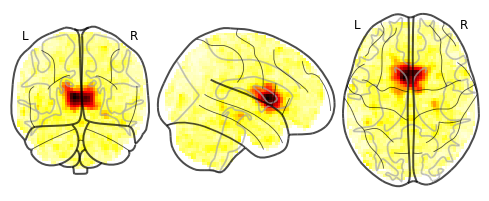

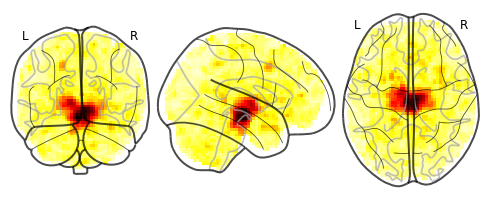

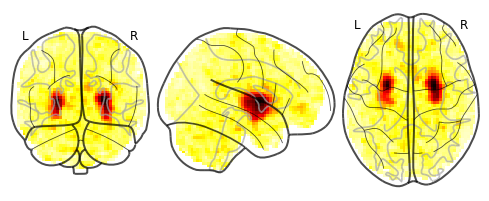

In [16]:
for i, img_slice in enumerate(nl.image.iter_img(img)):
    fig = nlplt.plot_glass_brain(img_slice)
    nlplt.show()
#     fig.savefig('')
#     fig.close()
    if i>1: break

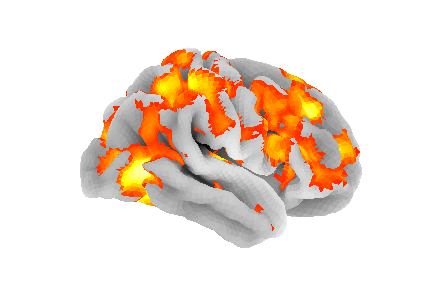

In [15]:
# for i, img_slice in enumerate(nl.image.iter_img(img)):
#     if i==30:

mean_img = nl.image.mean_img(img)
fsaverage = nl.datasets.fetch_surf_fsaverage()
texture = nl.surface.vol_to_surf(mean_img, fsaverage.pial_right)
fig = nlplt.plot_surf_stat_map(fsaverage.pial_right, texture, hemi='right',
                               view='lateral', colorbar=False,
                               threshold=.2, bg_map=fsaverage.sulc_right)
#                                output_file='figures/fMRI_3D_R_10004_mean.png')
nlplt.show()

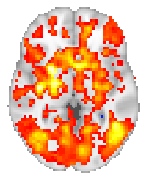

In [63]:
i = 0
mean_img = nl.image.mean_img(img)
fig = nlplt.plot_stat_map(mean_img, threshold=.2, display_mode='z', cut_coords=[i],
                          colorbar=False, annotate=False, black_bg=False)
#                           output_file='figures/fMRI_2D_10004_'+str(i)+'.png')
nlplt.show()

<h3>As Numpy Array</h3>

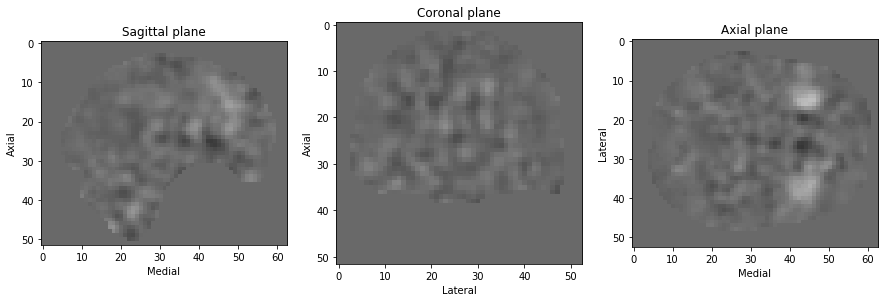

Y=53 (lateral: left-right), X=63 (medial: front-back), Z=52 (axial: top-bottom), T=53 (temporal: time)
Min value: -8.08287525177002 Max value: 11.52772331237793


In [6]:
t    = 26
fig  = plt.figure(figsize=(15,5))
cmap = 'gray' # cividis, gray

ax = plt.subplot(131)
plt.imshow(np.rot90(data[26,:,:,t]),cmap=cmap,vmin=np.min(data),vmax=np.max(data))
# fig.suptitle('test title', fontsize=20)
plt.xlabel('Medial')
plt.ylabel('Axial')
ax.set_title('Sagittal plane')

ax = plt.subplot(132)
plt.imshow(np.rot90(data[:,31,:,t]),cmap=cmap,vmin=np.min(data),vmax=np.max(data))
plt.xlabel('Lateral')
plt.ylabel('Axial')
ax.set_title('Coronal plane')

ax = plt.subplot(133)
plt.imshow(data[:,:,26,t],cmap=cmap,vmin=np.min(data),vmax=np.max(data))
plt.xlabel('Medial')
plt.ylabel('Lateral')
ax.set_title('Axial plane')

plt.show()
# plt.savefig('figures/fMRI_example_10004.png', bbox_inches='tight')

print('Y=%d (lateral: left-right), X=%d (medial: front-back), Z=%d (axial: top-bottom), T=%d (temporal: time)'%data.shape)
print('Min value:',np.min(data),'Max value:',np.max(data))

<h2>Pre-processing steps (from DeepLight)</h2>

<h3>Smoothing</h3>

- volume-based smoothing of the fMRI sequences with a 3 mm Gaussian kernel

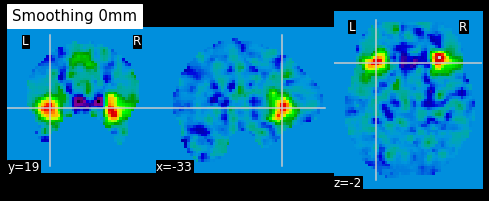

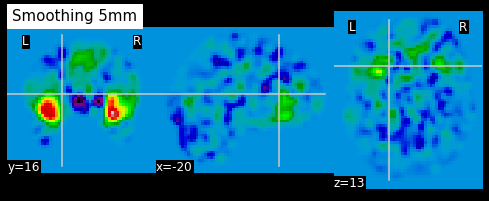

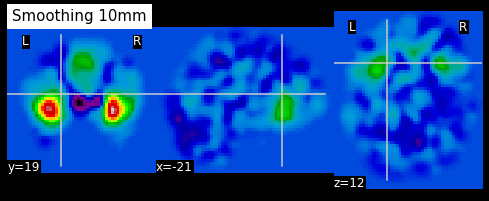

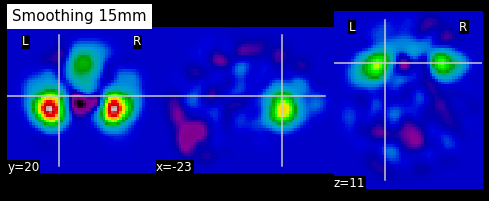

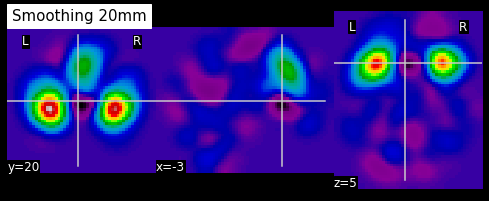

In [32]:
mean_func = nl.image.mean_img(img)
for smoothing in range(0, 25, 5):
#     smoothed_img = nl.image.smooth_img(mean_func, smoothing)
    smoothed_img = nl.image.smooth_img(img, smoothing)
    for i, img_slice in enumerate(nl.image.iter_img(smoothed_img)):
        if i==26:
            nlplt.plot_epi(img_slice, title='Smoothing %imm'%smoothing)

<h3>Linear detrending, standardization and </h3>

- linear detrending and standardization of the single voxel signal time-series (resulting in a zero-centered voxel time-series with unit variance)

- temporal filtering of the single voxel time-series with a butterworth highpass filter and a cutoff of 128s

In [33]:
mean_img   = nl.image.mean_img(img)
smooth_img = nl.image.smooth_img(img, 3)
clean_img  = nl.image.clean_img(smooth_img, detrend=True, standardize='zscore') #, high_pass=128, t_r=.25)
prepr_data = nl.image.get_data(clean_img)
print(prepr_data.shape)

(53, 63, 52, 53)


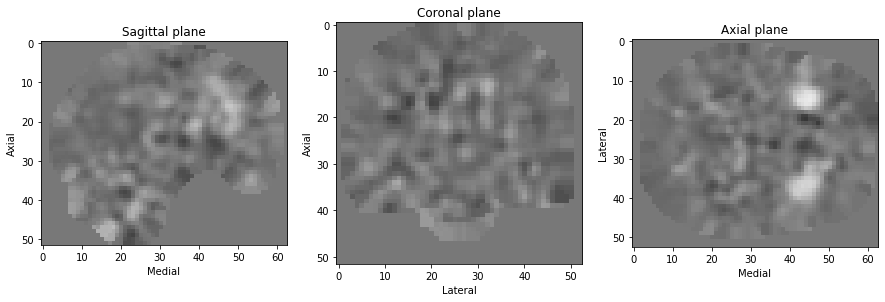

Y=53 (lateral: left-right), X=63 (medial: front-back), Z=52 (axial: top-bottom), T=53 (temporal: time)
Min value: -5.9599471477136925 Max value: 6.730476282612882


In [34]:
t    = 26
fig  = plt.figure(figsize=(15,5))
cmap = 'gray' # cividis, gray

ax = plt.subplot(131)
plt.imshow(np.rot90(prepr_data[26,:,:,t]),cmap=cmap,vmin=np.min(prepr_data),vmax=np.max(prepr_data))
# fig.suptitle('test title', fontsize=20)
plt.xlabel('Medial')
plt.ylabel('Axial')
ax.set_title('Sagittal plane')

ax = plt.subplot(132)
plt.imshow(np.rot90(prepr_data[:,31,:,t]),cmap=cmap,vmin=np.min(prepr_data),vmax=np.max(prepr_data))
plt.xlabel('Lateral')
plt.ylabel('Axial')
ax.set_title('Coronal plane')

ax = plt.subplot(133)
plt.imshow(prepr_data[:,:,26,t],cmap=cmap,vmin=np.min(prepr_data),vmax=np.max(prepr_data))
plt.xlabel('Medial')
plt.ylabel('Lateral')
ax.set_title('Axial plane')

plt.show()
# plt.savefig('figures/fMRI_example_10004.png', bbox_inches='tight')

print('Y=%d (lateral: left-right), X=%d (medial: front-back), Z=%d (axial: top-bottom), T=%d (temporal: time)'%prepr_data.shape)
print('Min value:',np.min(prepr_data),'Max value:',np.max(prepr_data))